In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib import gridspec
from uncertainties import ufloat
from uncertainties.umath import * 
from uncertainties import unumpy as unp
from scipy.optimize import curve_fit
from scipy.special import factorial

In [2]:
Exp1 = pd.read_excel('../data/Exp1.xlsx')
Exp2 = pd.read_excel('../data/Exp2.xlsx')
Exp3 = pd.read_excel('../data/Exp3.xlsx')
Exp4 = pd.read_excel('../data/Exp4.xlsx')
Bonus = pd.read_excel('../data/Bonus.xlsx')
Back = pd.read_excel('../data/Background.xlsx')
Tech = pd.read_excel('../data/Tech.xlsx')

In [3]:
def cropdf(data, mins):
    lim = mins*60
    return data.loc[(data[data.columns[0]] <= lim)]

In [4]:
Exp1, Exp2, Exp4 = cropdf(Exp1, 5), cropdf(Exp2, 5), cropdf(Exp4, 5)
Exp3 = cropdf(Exp3, 1)
Back1min = cropdf(Back[Back.columns[:2]], 1)
Back5min = cropdf(Back[Back.columns[2:]], 5)

In [5]:
def getcounts(data):
    return data[data.columns[1:len(data.axes[1]):2]]

In [6]:
cExp1, cExp2, cExp3, cExp4, cTech = getcounts(Exp1), getcounts(Exp2), getcounts(Exp3), getcounts(Exp4), getcounts(Tech)
cBack1min, cBack5min = getcounts(Back1min), getcounts(Back5min)
cBonus = getcounts(Bonus) #to get a np matrix just use df.values then each column is a run

In [7]:
cBonus = cBonus[['Bonus 4.95.1', 'Bonus 5.1.1', 'Bonus 5.30.1', 'Bonus 5.9.1', 'Bonus 7.10.1', 'Bonus 8.00.1', 'Bonus 8.90.1', 'Bonus 15.4.1']]
cBonus.head()

,Bonus 4.95.1,Bonus 5.1.1,Bonus 5.30.1,Bonus 5.9.1,Bonus 7.10.1,Bonus 8.00.1,Bonus 8.90.1,Bonus 15.4.1
0,8,4,5,2,1,1,0,0
1,4,6,2,6,1,3,1,0
2,10,3,1,3,2,1,1,1
3,6,5,4,4,1,2,0,0
4,5,8,3,3,3,2,0,1


In [8]:
def calcbins(data, binwidth=1):
    return np.arange(min(data), max(data) + binwidth, binwidth)
def replaceval(data, to_replace=0):
    return data.replace(to_replace, value=np.nan)

In [9]:
cBack1min, cBack5min = replaceval(cBack1min), replaceval(cBack5min)

In [10]:
pd.options.mode.chained_assignment = None  # default='warn'
def addsumdf(data, name, axis=1):
    data[name] = data.sum(axis)
    return data
def addavgdf(data, name, axis=1):
    data[name] = data.sum(axis) / data.shape[1]
    return data

In [11]:
cExp3_vertical = cExp3.sum(axis=0)
cExp1 = addsumdf(cExp1, 'Exp1 Horizontal Sum')
cExp2 = addsumdf(cExp2, 'Exp2 Horizontal Sum')
cExp2 = addavgdf(cExp2, 'Exp2 Horizontal Average')
cExp3 = addsumdf(cExp3, 'Exp3 Horizontal Sum')
cExp4 = addsumdf(cExp4, 'Exp4 Horizontal Sum')

In [12]:
def gauss_function(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))
def poisson_function(x, a, mu):
    return a*(mu**x)*(np.e**(-mu))/(factorial(x))

In [13]:
def errors(pcov): 
    return np.sqrt(np.diag(pcov))
def totalerr(pcov):
    return np.sqrt(sum(x**2 for x in errors(pcov)))

93.38250380629833


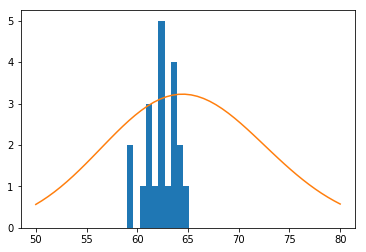

In [14]:
cAllExp_no3 = [cExp3_vertical]

e = cExp3_vertical/20
plt.hist(e)
print(np.std(e)**10)
testerx= np.linspace(50, 80)
plt.plot(testerx, poisson_function(testerx, np.max(e), np.std(e)**9.2))
plt.show()

In [15]:
def extract_and_plot_stuff(run, numtrials, bgdata, rundata, binwidth, plotGauss=True, plotPoisson=True):
    bg_hist, bins = np.histogram(bgdata, bins=calcbins(rundata, binwidth))
    data_hist, _ = np.histogram(rundata, bins=calcbins(rundata, binwidth))

    plot_hist = data_hist
    for i in np.nonzero(bg_hist)[0]:
        plot_hist[i] = plot_hist[i] - bg_hist[i] if data_hist[i] - bg_hist[i] > 0 else 0

    histx = [0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins)-1)]

    data_mean_guess = rundata.mean()
    data_std_guess = rundata.std()
    data_a_guess = max(plot_hist)
    
    fig, (a0, a1) = plt.subplots(nrows=2, ncols=1, gridspec_kw = {'height_ratios':[3, 1]}, sharex=True, figsize=(6,6))
    fig.subplots_adjust(hspace=.08)
    a0.bar(bins[:-1], plot_hist, width=.8*binwidth, yerr=np.sqrt(plot_hist), ecolor='gray', capsize=3, alpha=0.75) 
    xdata = np.linspace(min(bins), max(bins)) #for plotting g and p

#     print(type(plot_hist), type(bins))
    if plotGauss == True:
        gauss_params, gauss_cov = curve_fit(gauss_function,histx,plot_hist,p0=(data_a_guess,data_mean_guess,data_std_guess))
        residuals_gauss = gauss_function(histx, *gauss_params) - plot_hist
        mu_err = 2*errors(gauss_cov)[2]*gauss_params[2]
        print('Gaussian fit: a=', '%.2f'%gauss_params[0], '+/-', '%.2f'%errors(gauss_cov)[0] ,
              ', x0=', '%.2f'%gauss_params[1], '+/-',  '%.2f'%errors(gauss_cov)[1],
              ', sigma=sqrt(mu)=', '%.2f'%gauss_params[2], '+/-',  '%.2f'%errors(gauss_cov)[2], 
              'ie mu = ', '%.2f'%(gauss_params[2]**2), '+/-', '%.2f'%mu_err)
        a0.plot(xdata, gauss_function(xdata, *gauss_params), 'r', label='Gaussian Fit')

        k_gauss = totalerr(gauss_cov) # standardized residuals = residuals / error 
        a1.errorbar(histx, residuals_gauss/k_gauss, yerr = np.sqrt(plot_hist), marker='.', color='r', linestyle='None', 
                    capsize=3, label='Gaus.')
    if plotPoisson == True:
        mu_guess = data_std_guess**2
        if plotGauss: mu_guess = gauss_params[2]**2
        poisson_params, poisson_cov = curve_fit(poisson_function, histx, plot_hist, p0=(data_a_guess, mu_guess))
        residuals_poisson = poisson_function(histx, *poisson_params) - plot_hist
        print('Poisson fit: a=', '%.2f'%poisson_params[0], '+/-', '%.2f'%errors(poisson_cov)[0],
              ', mu=sigma^2=', '%.2f'%poisson_params[1], '+/-', '%.2f'%errors(poisson_cov)[1])

        a0.plot(xdata, poisson_function(xdata, *poisson_params), 'g', label='Poisson Fit')
        k_poisson = totalerr(poisson_cov)
        a1.errorbar(histx, residuals_poisson/k_poisson, yerr=np.sqrt(plot_hist), marker='.', color='g', linestyle='None', 
                    capsize=3, label='Pois.')
        
    title = run[:-2] if '.1' in run else run
    a0.set_title(title)
    a0.set_ylabel('Occurences')
    a1.set_xlabel('Counts per time bin')
    a1.set_ylabel('Std. Residuals')
    if plotGauss or plotPoisson: a0.legend(); a1.legend(loc='upper right')
#     SAVEFIG STUFF
    plt.show()
    if plotGauss:
        mu_gauss_out, err_gauss_out = gauss_params[2]**2, mu_err 
        if 'Sum' in run:  mu_gauss_out, err_gauss_out = mu_gauss_out/numtrials, err_gauss_out/numtrials 
    if plotPoisson: 
        mu_poisson_out, err_poisson_out = poisson_params[1], errors(poisson_cov)[1]
        if 'Sum' in run: mu_poisson_out, err_poisson_out = mu_poisson_out/numtrials, err_poisson_out/numtrials
            
    if plotGauss and plotPoisson: 
        return [mu_gauss_out, mu_poisson_out], [err_gauss_out, err_poisson_out]
    elif plotGauss:
        return [mu_gauss_out], [err_gauss_out]
    elif plotPoisson:
        return [mu_poisson_out], [err_poisson_out]

In [16]:
def newdf_rebin(data, name, rebin):
    series = data.groupby(data.index // rebin).sum()
    return series.to_frame(name=name)

In [17]:
cTechbin2 = newdf_rebin(cTech['Tech'], 'Tech Bin2', 2)
cTechbin5 = newdf_rebin(cTech['Tech'], 'Tech Bin5', 5)
cTechbin20 = newdf_rebin(cTech['Tech'], 'Tech Bin20', 20)
print(len(cTech), len(cTechbin2), len(cTechbin5), len(cTechbin20))

27001 13501 5401 1351


In [18]:
cAllExp = [cExp1, cExp2, cExp3, cExp4, cBonus, cTech, cTechbin2, cTechbin5, cTechbin20, cExp3_vertical]

In [42]:
fitting_out = [[] for x in range(len(cAllExp))]
error_out = [[] for x in range(len(cAllExp))]

In [43]:
for e in cAllExp[:-1]:
    print(sum([1 if not ('Sum' in x or 'Average' in x) else 0 for x in e.columns]))

3
3
20
5
8
1
1
1
1


Gaussian fit: a= 339.97 +/- 10.88 , x0= 3.67 +/- 0.06 , sigma=sqrt(mu)= 1.66 +/- 0.06 ie mu =  2.76 +/- 0.21
Poisson fit: a= 1522.15 +/- 73.94 , mu=sigma^2= 3.93 +/- 0.13


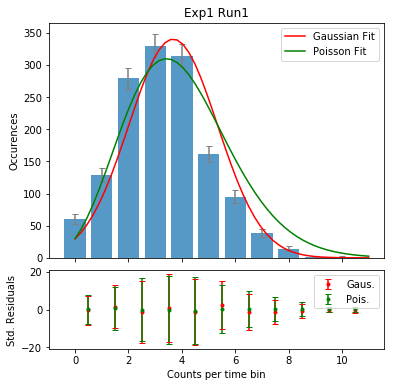

Gaussian fit: a= 334.82 +/- 15.85 , x0= 3.69 +/- 0.09 , sigma=sqrt(mu)= 1.71 +/- 0.10 ie mu =  2.91 +/- 0.32
Poisson fit: a= 1524.04 +/- 77.84 , mu=sigma^2= 3.95 +/- 0.14


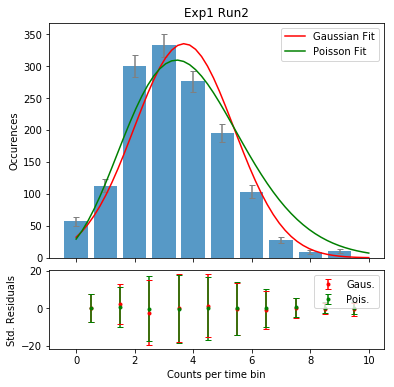

Gaussian fit: a= 354.15 +/- 18.98 , x0= 3.56 +/- 0.10 , sigma=sqrt(mu)= 1.58 +/- 0.10 ie mu =  2.49 +/- 0.31
Poisson fit: a= 1532.52 +/- 98.02 , mu=sigma^2= 3.84 +/- 0.17


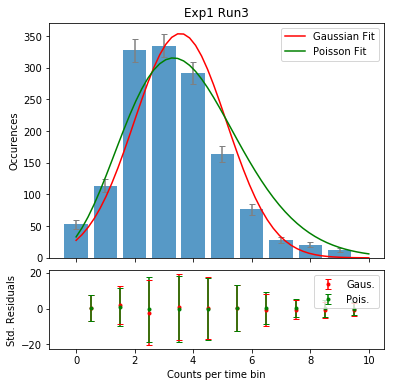

Gaussian fit: a= 198.94 +/- 4.97 , x0= 9.94 +/- 0.09 , sigma=sqrt(mu)= 2.96 +/- 0.09 ie mu =  8.76 +/- 0.50
Poisson fit: a= 1528.46 +/- 30.05 , mu=sigma^2= 10.20 +/- 0.09


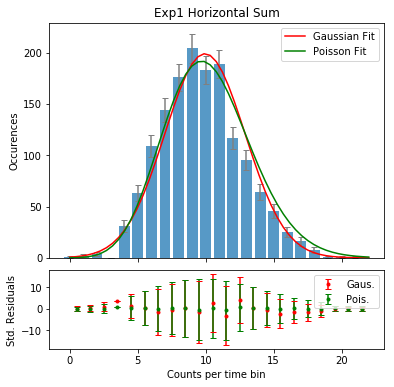

Gaussian fit: a= 9.24 +/- 0.91 , x0= 41.88 +/- 0.74 , sigma=sqrt(mu)= 6.52 +/- 0.76 ie mu =  42.46 +/- 9.89
Poisson fit: a= 150.19 +/- 11.99 , mu=sigma^2= 42.15 +/- 0.73


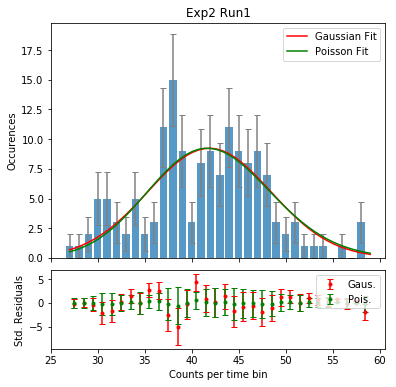

Gaussian fit: a= 9.17 +/- 0.60 , x0= 42.00 +/- 0.50 , sigma=sqrt(mu)= 6.69 +/- 0.53 ie mu =  44.75 +/- 7.05
Poisson fit: a= 151.34 +/- 7.96 , mu=sigma^2= 42.28 +/- 0.49


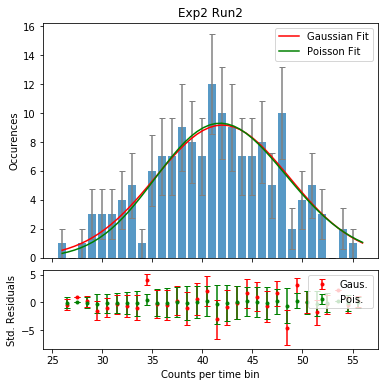

Gaussian fit: a= 8.90 +/- 0.67 , x0= 41.13 +/- 0.58 , sigma=sqrt(mu)= 6.74 +/- 0.60 ie mu =  45.38 +/- 8.04
Poisson fit: a= 146.75 +/- 8.82 , mu=sigma^2= 41.38 +/- 0.55


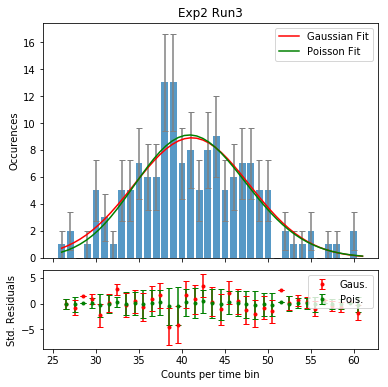

Gaussian fit: a= 4.63 +/- 0.42 , x0= 123.87 +/- 1.39 , sigma=sqrt(mu)= 13.26 +/- 1.42 ie mu =  175.79 +/- 37.63


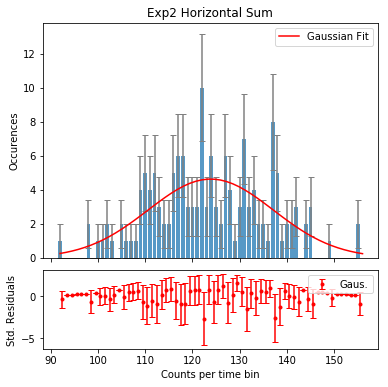

Gaussian fit: a= 9.30 +/- 0.72 , x0= 61.97 +/- 0.59 , sigma=sqrt(mu)= 6.59 +/- 0.60 ie mu =  43.45 +/- 7.91
Poisson fit: a= 167.11 +/- 11.08 , mu=sigma^2= 62.26 +/- 0.75


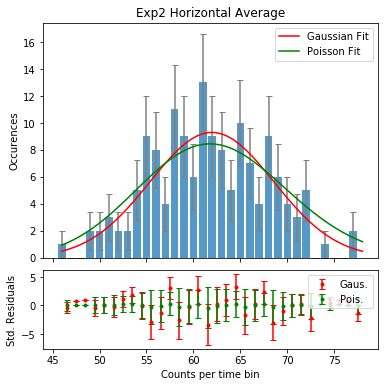

Gaussian fit: a= 168.99 +/- 6.70 , x0= 2.32 +/- 0.07 , sigma=sqrt(mu)= 1.40 +/- 0.07 ie mu =  1.97 +/- 0.20
Poisson fit: a= 625.52 +/- 29.62 , mu=sigma^2= 2.60 +/- 0.11


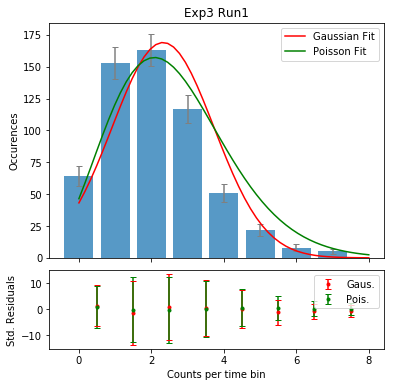

Gaussian fit: a= 159.36 +/- 3.75 , x0= 2.16 +/- 0.05 , sigma=sqrt(mu)= 1.56 +/- 0.05 ie mu =  2.45 +/- 0.16
Poisson fit: a= 611.52 +/- 16.20 , mu=sigma^2= 2.47 +/- 0.06


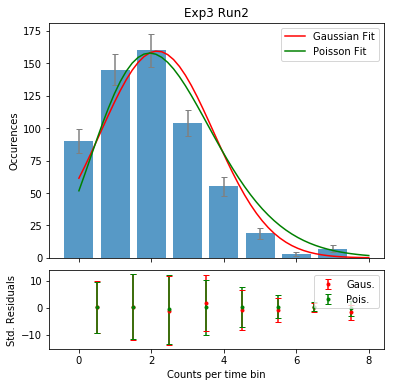

Gaussian fit: a= 147.30 +/- 5.15 , x0= 2.30 +/- 0.08 , sigma=sqrt(mu)= 1.73 +/- 0.09 ie mu =  2.99 +/- 0.30
Poisson fit: a= 604.02 +/- 6.56 , mu=sigma^2= 2.63 +/- 0.02


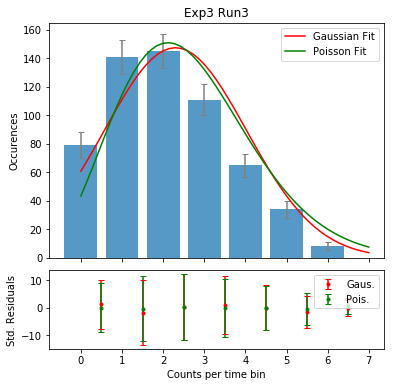

Gaussian fit: a= 156.07 +/- 5.12 , x0= 2.26 +/- 0.06 , sigma=sqrt(mu)= 1.59 +/- 0.07 ie mu =  2.52 +/- 0.23
Poisson fit: a= 610.46 +/- 21.31 , mu=sigma^2= 2.57 +/- 0.08


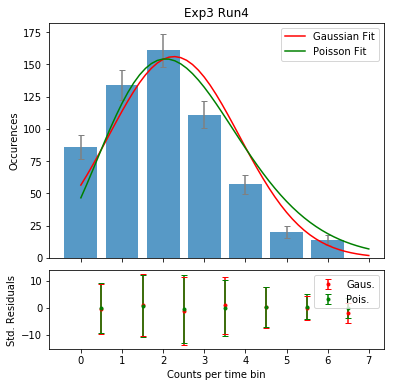

Gaussian fit: a= 146.22 +/- 2.63 , x0= 2.30 +/- 0.04 , sigma=sqrt(mu)= 1.72 +/- 0.04 ie mu =  2.97 +/- 0.15
Poisson fit: a= 598.21 +/- 6.11 , mu=sigma^2= 2.63 +/- 0.02


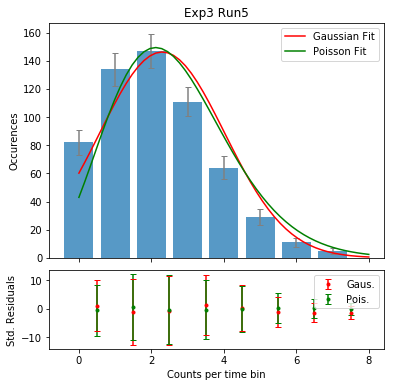

Gaussian fit: a= 162.29 +/- 8.71 , x0= 2.33 +/- 0.09 , sigma=sqrt(mu)= 1.45 +/- 0.10 ie mu =  2.11 +/- 0.29
Poisson fit: a= 612.96 +/- 30.03 , mu=sigma^2= 2.63 +/- 0.11


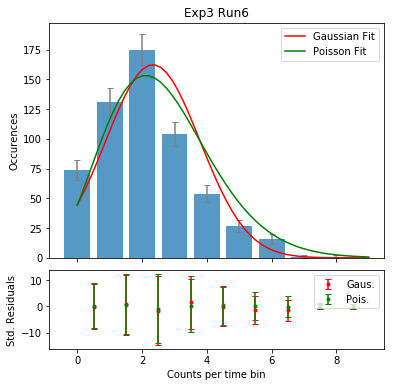

Gaussian fit: a= 157.62 +/- 5.62 , x0= 2.27 +/- 0.07 , sigma=sqrt(mu)= 1.56 +/- 0.08 ie mu =  2.43 +/- 0.23
Poisson fit: a= 612.58 +/- 13.97 , mu=sigma^2= 2.57 +/- 0.05


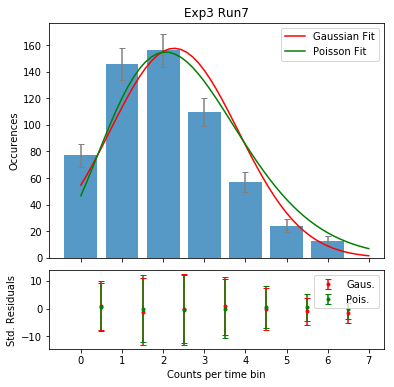

Gaussian fit: a= 161.22 +/- 10.28 , x0= 2.34 +/- 0.11 , sigma=sqrt(mu)= 1.49 +/- 0.12 ie mu =  2.22 +/- 0.37
Poisson fit: a= 616.15 +/- 37.15 , mu=sigma^2= 2.63 +/- 0.14


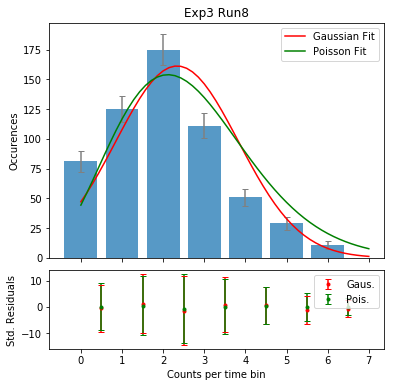

Gaussian fit: a= 162.60 +/- 4.17 , x0= 2.46 +/- 0.04 , sigma=sqrt(mu)= 1.48 +/- 0.05 ie mu =  2.20 +/- 0.14
Poisson fit: a= 625.87 +/- 27.84 , mu=sigma^2= 2.73 +/- 0.10


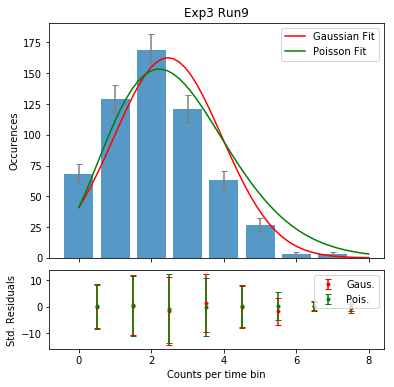

Gaussian fit: a= 150.54 +/- 7.46 , x0= 2.23 +/- 0.10 , sigma=sqrt(mu)= 1.64 +/- 0.11 ie mu =  2.70 +/- 0.38
Poisson fit: a= 599.24 +/- 16.17 , mu=sigma^2= 2.57 +/- 0.06


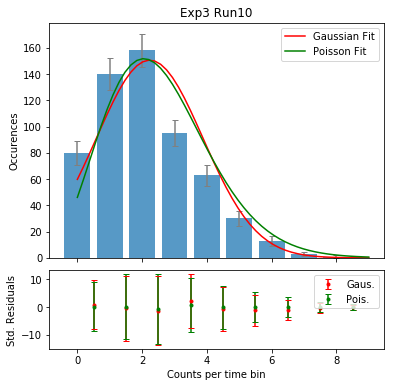

Gaussian fit: a= 158.04 +/- 10.95 , x0= 2.41 +/- 0.13 , sigma=sqrt(mu)= 1.54 +/- 0.14 ie mu =  2.36 +/- 0.43
Poisson fit: a= 618.48 +/- 35.44 , mu=sigma^2= 2.71 +/- 0.13


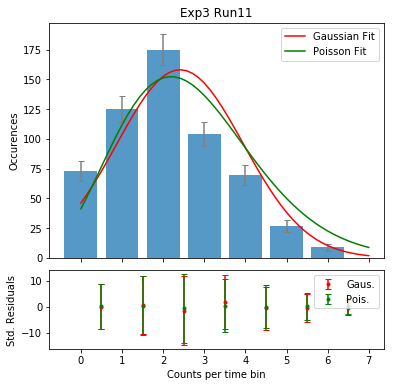

Gaussian fit: a= 161.77 +/- 7.08 , x0= 2.31 +/- 0.08 , sigma=sqrt(mu)= 1.50 +/- 0.09 ie mu =  2.24 +/- 0.26
Poisson fit: a= 619.19 +/- 21.80 , mu=sigma^2= 2.61 +/- 0.08


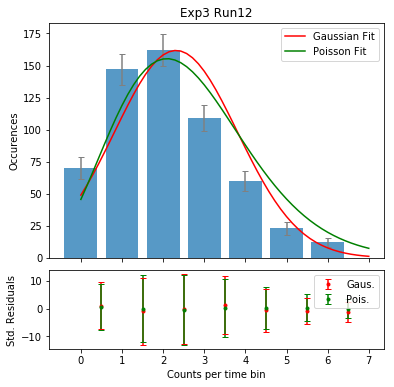

Gaussian fit: a= 161.68 +/- 7.27 , x0= 2.21 +/- 0.08 , sigma=sqrt(mu)= 1.51 +/- 0.09 ie mu =  2.27 +/- 0.28
Poisson fit: a= 614.75 +/- 18.55 , mu=sigma^2= 2.51 +/- 0.07


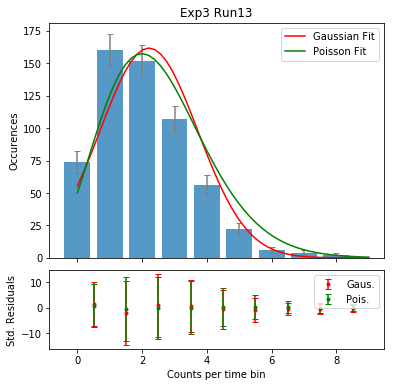

Gaussian fit: a= 173.55 +/- 10.29 , x0= 2.39 +/- 0.09 , sigma=sqrt(mu)= 1.34 +/- 0.10 ie mu =  1.80 +/- 0.26
Poisson fit: a= 629.52 +/- 48.06 , mu=sigma^2= 2.66 +/- 0.17


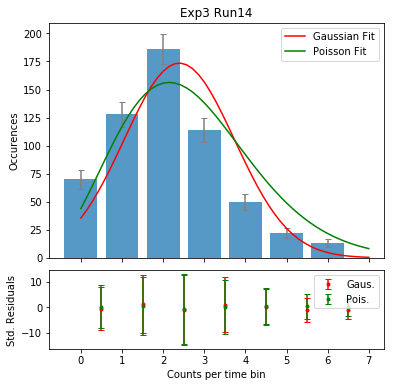

Gaussian fit: a= 160.22 +/- 7.28 , x0= 2.42 +/- 0.08 , sigma=sqrt(mu)= 1.50 +/- 0.09 ie mu =  2.25 +/- 0.26
Poisson fit: a= 619.97 +/- 28.41 , mu=sigma^2= 2.71 +/- 0.11


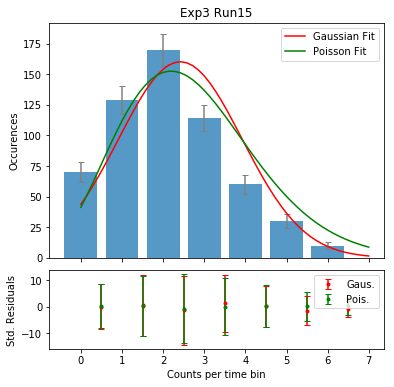

Gaussian fit: a= 162.51 +/- 3.37 , x0= 2.56 +/- 0.04 , sigma=sqrt(mu)= 1.48 +/- 0.04 ie mu =  2.20 +/- 0.11
Poisson fit: a= 628.35 +/- 34.27 , mu=sigma^2= 2.81 +/- 0.13


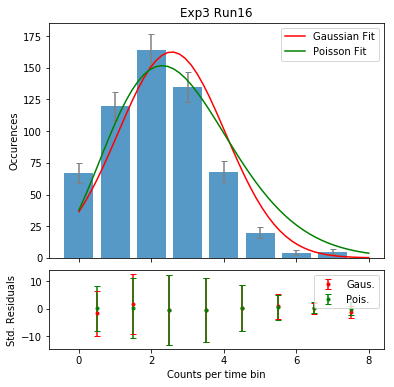

Gaussian fit: a= 163.02 +/- 7.49 , x0= 2.24 +/- 0.08 , sigma=sqrt(mu)= 1.50 +/- 0.09 ie mu =  2.26 +/- 0.28
Poisson fit: a= 620.16 +/- 24.00 , mu=sigma^2= 2.54 +/- 0.09


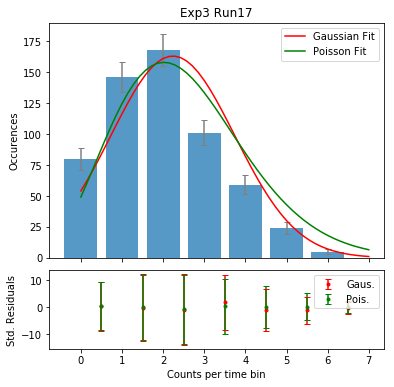

Gaussian fit: a= 159.22 +/- 7.38 , x0= 2.21 +/- 0.09 , sigma=sqrt(mu)= 1.52 +/- 0.10 ie mu =  2.32 +/- 0.29
Poisson fit: a= 608.28 +/- 20.30 , mu=sigma^2= 2.52 +/- 0.07


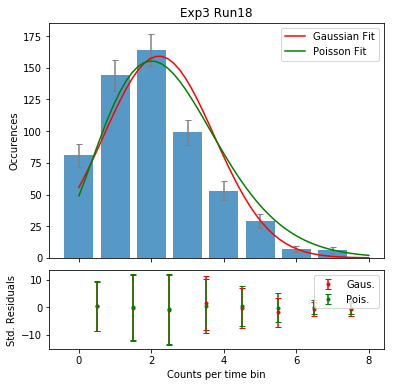

Gaussian fit: a= 164.33 +/- 5.45 , x0= 2.24 +/- 0.06 , sigma=sqrt(mu)= 1.47 +/- 0.06 ie mu =  2.15 +/- 0.19
Poisson fit: a= 617.11 +/- 22.96 , mu=sigma^2= 2.54 +/- 0.08


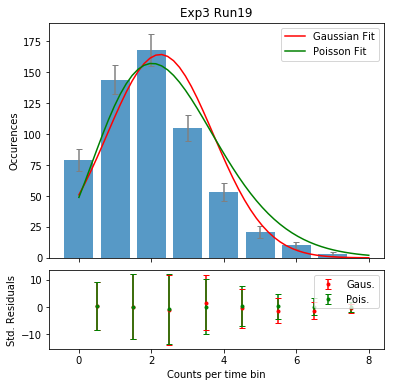

Gaussian fit: a= 156.51 +/- 4.10 , x0= 2.31 +/- 0.05 , sigma=sqrt(mu)= 1.56 +/- 0.05 ie mu =  2.44 +/- 0.17
Poisson fit: a= 609.86 +/- 19.70 , mu=sigma^2= 2.61 +/- 0.07


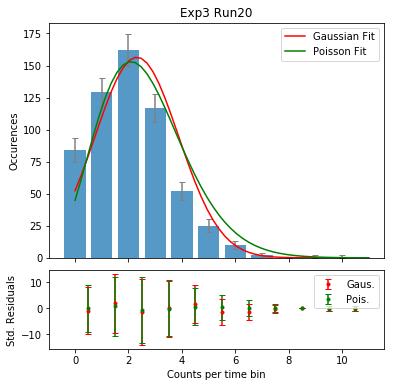

Gaussian fit: a= 36.78 +/- 1.05 , x0= 41.53 +/- 0.22 , sigma=sqrt(mu)= 6.56 +/- 0.22 ie mu =  43.06 +/- 2.85
Poisson fit: a= 600.18 +/- 13.38 , mu=sigma^2= 41.77 +/- 0.20


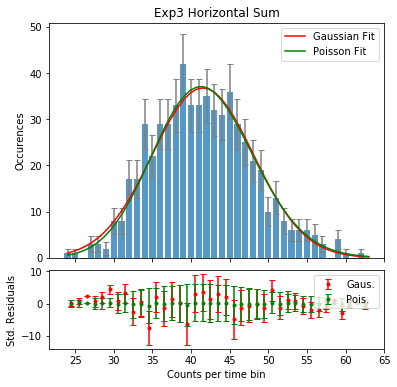

Gaussian fit: a= 24.28 +/- 1.94 , x0= 6.76 +/- 0.22 , sigma=sqrt(mu)= 2.39 +/- 0.22 ie mu =  5.70 +/- 1.06
Poisson fit: a= 152.68 +/- 9.16 , mu=sigma^2= 7.03 +/- 0.22


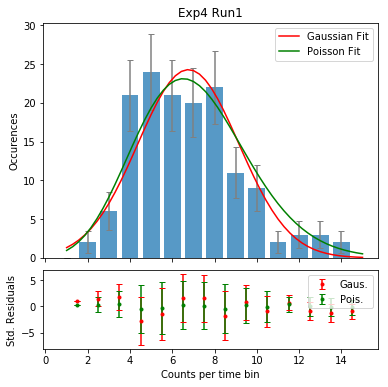

Gaussian fit: a= 25.26 +/- 0.97 , x0= 7.45 +/- 0.10 , sigma=sqrt(mu)= 2.32 +/- 0.10 ie mu =  5.37 +/- 0.48
Poisson fit: a= 158.75 +/- 7.60 , mu=sigma^2= 7.69 +/- 0.19


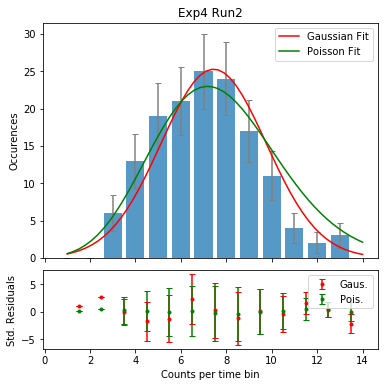

Gaussian fit: a= 23.04 +/- 1.54 , x0= 7.60 +/- 0.20 , sigma=sqrt(mu)= 2.61 +/- 0.21 ie mu =  6.83 +/- 1.08
Poisson fit: a= 154.92 +/- 8.97 , mu=sigma^2= 7.82 +/- 0.23


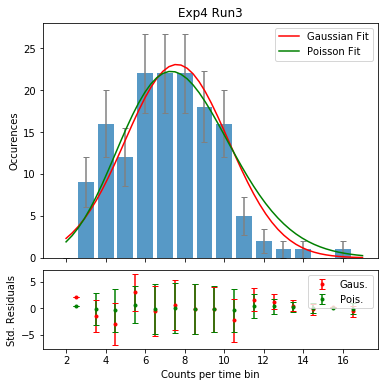

Gaussian fit: a= 21.64 +/- 1.80 , x0= 7.34 +/- 0.27 , sigma=sqrt(mu)= 2.78 +/- 0.27 ie mu =  7.71 +/- 1.52
Poisson fit: a= 150.17 +/- 8.42 , mu=sigma^2= 7.58 +/- 0.22


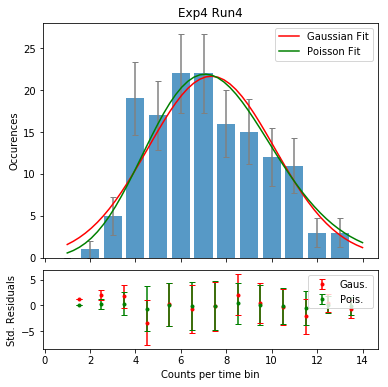

Gaussian fit: a= 23.94 +/- 1.59 , x0= 7.47 +/- 0.19 , sigma=sqrt(mu)= 2.44 +/- 0.19 ie mu =  5.94 +/- 0.91
Poisson fit: a= 155.12 +/- 8.90 , mu=sigma^2= 7.72 +/- 0.23


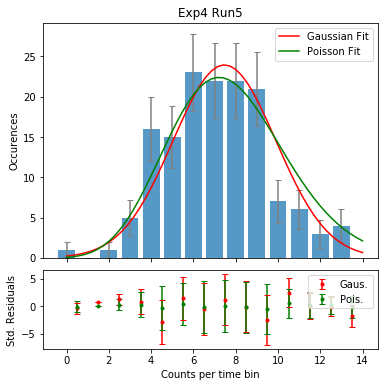

Gaussian fit: a= 11.35 +/- 0.94 , x0= 35.78 +/- 0.50 , sigma=sqrt(mu)= 5.21 +/- 0.51 ie mu =  27.18 +/- 5.34
Poisson fit: a= 158.59 +/- 10.97 , mu=sigma^2= 36.05 +/- 0.60


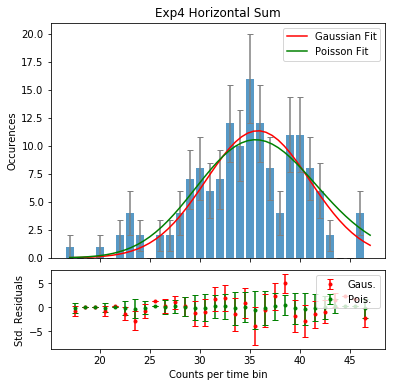

Gaussian fit: a= 50.16 +/- 2.81 , x0= 5.77 +/- 0.14 , sigma=sqrt(mu)= 2.20 +/- 0.14 ie mu =  4.85 +/- 0.63
Poisson fit: a= 290.66 +/- 13.43 , mu=sigma^2= 6.04 +/- 0.16


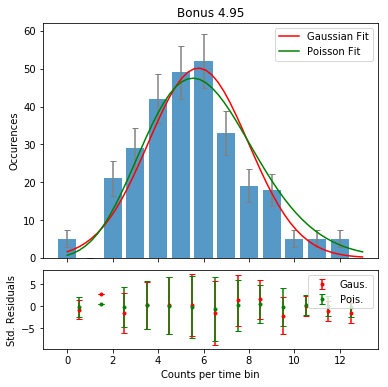

Gaussian fit: a= 55.94 +/- 4.46 , x0= 5.01 +/- 0.19 , sigma=sqrt(mu)= 2.05 +/- 0.20 ie mu =  4.18 +/- 0.80
Poisson fit: a= 303.01 +/- 17.16 , mu=sigma^2= 5.30 +/- 0.18


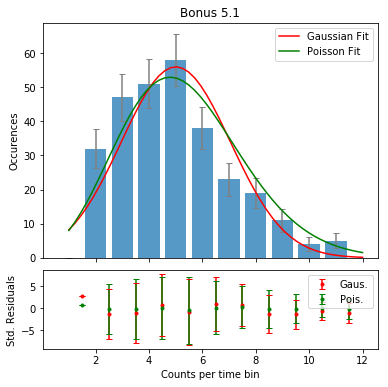

Gaussian fit: a= 54.37 +/- 6.30 , x0= 4.80 +/- 0.28 , sigma=sqrt(mu)= 2.10 +/- 0.30 ie mu =  4.40 +/- 1.24
Poisson fit: a= 298.04 +/- 22.16 , mu=sigma^2= 5.12 +/- 0.24


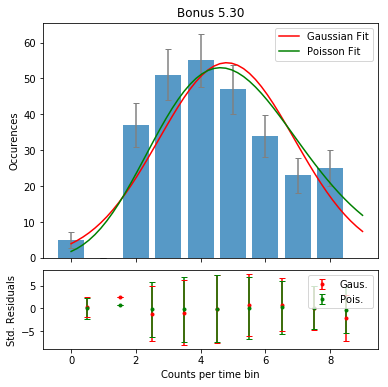

Gaussian fit: a= 82.78 +/- 15.03 , x0= 3.23 +/- 0.22 , sigma=sqrt(mu)= 1.06 +/- 0.22 ie mu =  1.13 +/- 0.47
Poisson fit: a= 278.59 +/- 54.45 , mu=sigma^2= 3.61 +/- 0.52


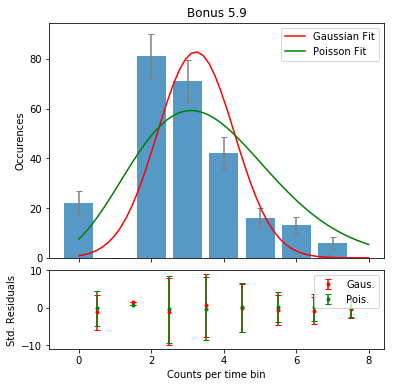

Gaussian fit: a= 56.54 +/- 17.07 , x0= 2.67 +/- 0.60 , sigma=sqrt(mu)= 1.70 +/- 0.70 ie mu =  2.89 +/- 2.39
Poisson fit: a= 237.39 +/- 54.37 , mu=sigma^2= 3.01 +/- 0.57


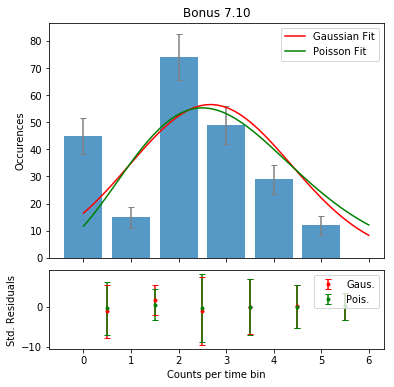

Poisson fit: a= 219.27 +/- 62.39 , mu=sigma^2= 1.69 +/- 0.53


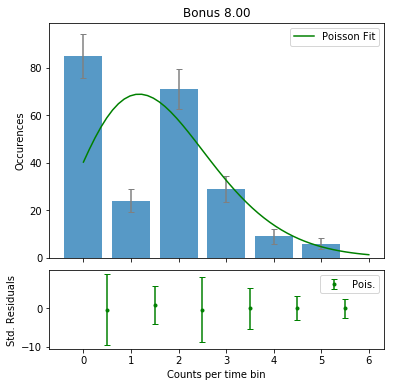

Poisson fit: a= 251.68 +/- 39.24 , mu=sigma^2= 0.71 +/- 0.25


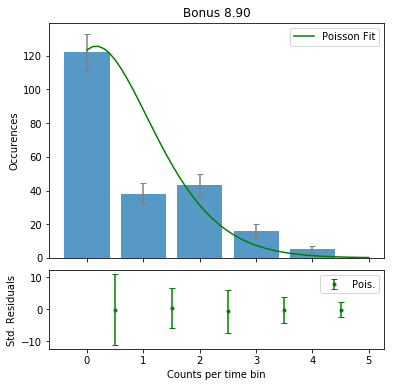

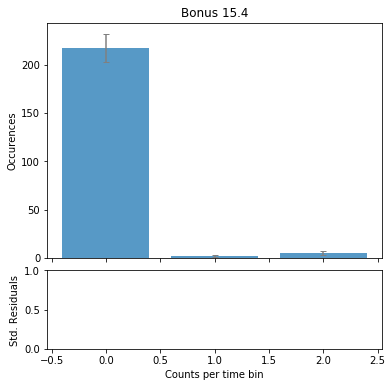

Gaussian fit: a= 7665.82 +/- 283.94 , x0= 2.24 +/- 0.06 , sigma=sqrt(mu)= 1.46 +/- 0.07 ie mu =  2.12 +/- 0.21
Poisson fit: a= 28701.60 +/- 960.52 , mu=sigma^2= 2.53 +/- 0.07


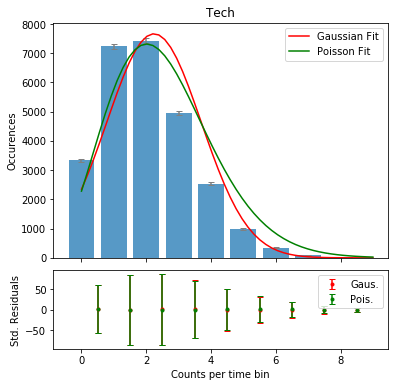

Gaussian fit: a= 2719.16 +/- 83.90 , x0= 4.34 +/- 0.07 , sigma=sqrt(mu)= 1.98 +/- 0.07 ie mu =  3.90 +/- 0.28
Poisson fit: a= 13939.44 +/- 271.76 , mu=sigma^2= 4.60 +/- 0.06


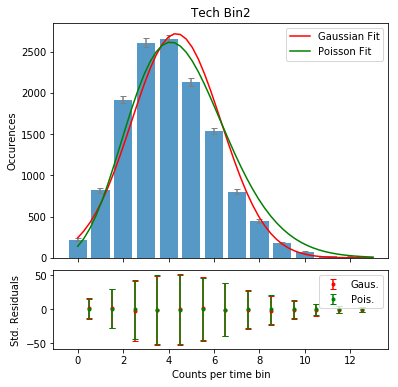

Gaussian fit: a= 691.19 +/- 16.22 , x0= 10.42 +/- 0.08 , sigma=sqrt(mu)= 3.11 +/- 0.08 ie mu =  9.65 +/- 0.52
Poisson fit: a= 5509.89 +/- 83.85 , mu=sigma^2= 10.68 +/- 0.07


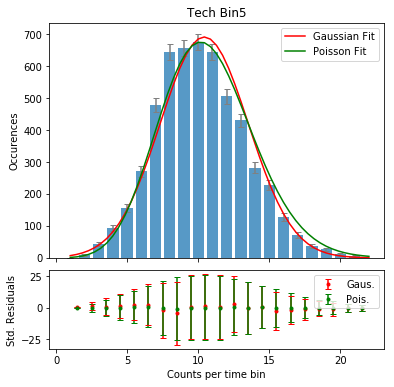

Gaussian fit: a= 87.80 +/- 1.81 , x0= 41.22 +/- 0.15 , sigma=sqrt(mu)= 6.11 +/- 0.15 ie mu =  37.39 +/- 1.78
Poisson fit: a= 1378.35 +/- 24.49 , mu=sigma^2= 41.45 +/- 0.16


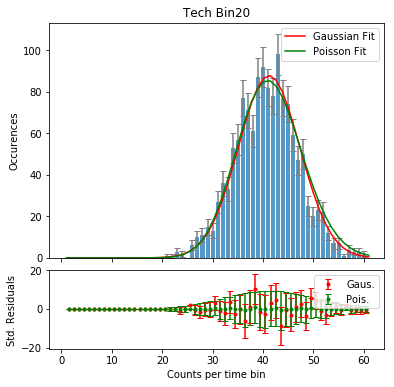

Gaussian fit: a= 2.36 +/- 0.52 , x0= 1251.73 +/- 9.36 , sigma=sqrt(mu)= 36.35 +/- 10.82 ie mu =  1321.16 +/- 786.42


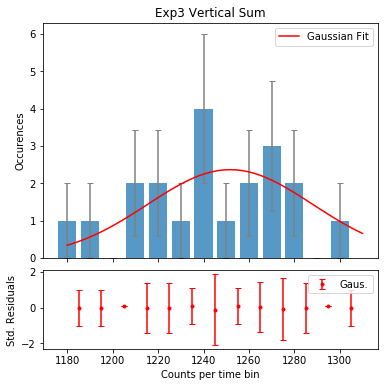

In [44]:
count = 0
for exp in cAllExp:
    binwidth=1
    bgdata = cBack5min['Background 5min.1']
    if (type(exp)== pd.core.frame.DataFrame and 'Exp3' in list(exp)[0]) or type(exp) == pd.core.series.Series:
        bgdata = cBack1min['Background 1min.1']
            
    if type(exp) == pd.core.series.Series: # vertically added Exp3
        binwidth=10
        plotGauss, plotPoisson = True, False
        mu_fit, mu_error = extract_and_plot_stuff('Exp3 Vertical Sum', 1, bgdata, exp, binwidth, plotGauss, plotPoisson) 
        fitting_out[count] += mu_fit 
        error_out[count] += mu_error
        break
    for run in exp:
        numtrials = sum([1 if not ('Sum' in x or 'Average' in x) else 0 for x in exp.columns])
        plotGauss, plotPoisson = True, True
        if 'Sum' in run:
            bgdata = (exp.shape[1]-1)*bgdata #for summed we add num_run times? I guess? 
            if 'Exp2' in run and 'Sum':
                plotPoisson = False
        if 'Bonus 8.' in run : plotGauss, plotPoisson = False, True
        if 'Bonus 15.' in run : plotGauss, plotPoisson = False, False
        if plotGauss or plotPoisson:
            mu_fit, mu_error = extract_and_plot_stuff(run, numtrials, bgdata, exp[run], binwidth, plotGauss, plotPoisson)
            fitting_out[count] += mu_fit 
            error_out[count] += mu_error
        else: 
            _ = extract_and_plot_stuff(run, numtrials, bgdata, exp[run], binwidth, plotGauss, plotPoisson)
    count+=1 

In [45]:
sqrt_errors_out = [[] for x in cAllExp]

In [66]:
def output_mean(data, rate):
    sqrt_errs = np.sqrt(data)
    m = np.average(data, weights=np.power(sqrt_errs,-2))
    e = np.sqrt(1/sum(np.power(sqrt_errs,-2)))
    print('ERROR WEIGHTED MEAN:', '%.2f'%m, '+/-', '%.2f'%e)
    print('with rate', rate)
    print('MEAN:' '%.2f'%(m*rate), '+/-', '%.2f'%(e*rate))
    return m*rate,e*rate

In [71]:
print('EXP 1')
rates, errs = [0,0,0,0], [0,0,0,0]
rates[0], errs[0] = output_mean(fitting_out[0], 5)

EXP 1
ERROR WEIGHTED MEAN: 3.18 +/- 0.63
with rate 5
MEAN:15.92 +/- 3.15


In [72]:
print('Exp 2')
rates[1], errs[1] = output_mean(fitting_out[1], 0.5)

Exp 2
ERROR WEIGHTED MEAN: 46.01 +/- 2.26
with rate 0.5
MEAN:23.00 +/- 1.13


In [73]:
print('Exp 3')
rates[2], errs[2] = output_mean(fitting_out[2], 10)

Exp 3
ERROR WEIGHTED MEAN: 2.43 +/- 0.24
with rate 10
MEAN:24.33 +/- 2.41


In [75]:
print('Exp 4')
rates[3], errs[3] = output_mean(fitting_out[3], 0.5)

Exp 4
ERROR WEIGHTED MEAN: 6.70 +/- 0.75
with rate 0.5
MEAN:3.35 +/- 0.37


Text(0,0.5,'Count Rate')

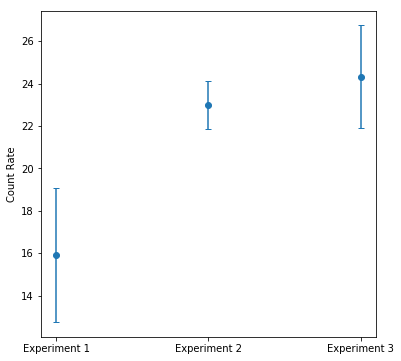

In [93]:
plt.figure(figsize=(6,6))
plt.errorbar([1,2,3], rates[:3], yerr=errs[:3], marker='o', capsize=3, linestyle='None')
plt.xticks([1,2,3], ['Experiment 1','Experiment 2','Experiment 3'])
plt.ylabel('Count Rate')

In [98]:
fitting_out[4]

[4.851908738565763,
 6.041820070707644,
 4.183662116018658,
 5.3003540603107675,
 4.401900813492177,
 5.118250341264298,
 1.1273140042049408,
 3.607912888220617,
 2.8927142873999716,
 3.013306523325433,
 1.6942718747408902,
 0.7121760991277376]

In [99]:
bonus_x = np.array([4.95, 5.1, 5.3, 5.9, 7.1, 8, 8.9]) - 4.6
bonus_x

array([0.35, 0.5 , 0.7 , 1.3 , 2.5 , 3.4 , 4.3 ])

In [114]:
bonus_counts = [fitting_out[4][1], fitting_out[4][3], fitting_out[4][4], fitting_out[4][7], fitting_out[4][9], fitting_out[4][10], fitting_out[4][11] ]
bonus_counts_errs = np.sqrt(bonus_counts)
# _, _ = output_mean(fitting_out[4][:2], 5)
# _, _ = output_mean(fitting_out[4][2:4], 5)
# # bonus_counts.append()

<Container object of 3 artists>

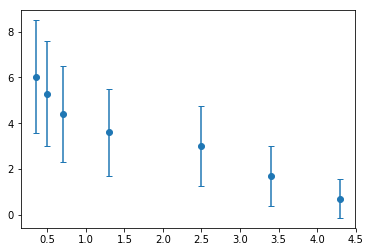

In [119]:
plt.errorbar(bonus_x, bonus_counts, yerr=bonus_counts_errs, marker='o', capsize=3, linestyle='None')